# Libraries

In [1]:
from datetime import date, datetime
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
# pd.options.display.float_format = '{:.2f}'.format
import matplotlib.pyplot as plt
import random
import re
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

In [2]:
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)
# import gspread
# from google.auth import default
# auth.authenticate_user()
# creds, _ = default()
# gc = gspread.authorize(creds)
# import requests
# from gspread_dataframe import set_with_dataframe
# from google.colab import files
# from datetime import datetime, timedelta
# from openpyxl import Workbook, load_workbook
# from openpyxl.styles import Font
# from googleapiclient.discovery import build
# from googleapiclient.http import MediaFileUpload

# Load data

In [3]:
schema = pd.read_csv('./survey_results_schema.csv')
survey = pd.read_csv('./survey_results_public.csv')

In [4]:
# enlace = 'https://drive.google.com/file/d/1-6xLuyL2QQsFOke6vEL7zHtEp2S5ZSdv/view?usp=drive_link' # survey 2023
# enlace = 'https://drive.google.com/file/d/1Qq5XIeyN3PrNUjuQAVqzVHlH4z0UWpjm/view?usp=drive_link' # survey 2023
# id = enlace.split('/')[-2]
# file = drive.CreateFile({'id': id})
# file.GetContentFile('survey.csv')
# survey = pd.read_csv('survey.csv')

# enlace = 'https://drive.google.com/file/d/1KfIllJ5m8tO7fZKbmJ4sFz6s3zgSqCLQ/view?usp=drive_link' # schema 2023
# enlace = 'https://drive.google.com/file/d/15It32kFBAtcN2Qs3XW9if4Xf8KUMUIHC/view?usp=drive_link' # schema 2023
# id = enlace.split('/')[-2]
# file = drive.CreateFile({'id': id})
# file.GetContentFile('schema.csv')
# schema = pd.read_csv('schema.csv')

# EDA and Data transformation

In [5]:
schema['type'].value_counts()

MC        48
Matrix    16
DB         9
TE         3
Meta       1
Slider     1
Name: type, dtype: int64

In [6]:
schema[schema['type'] == 'TE']

,qid,qname,question,force_resp,type,selector
24,QID51,CompTotal,What is your current total <b>annual</b> compe...,False,TE,SL
45,QID325,SOAI,Artificial Intelligence (AI) tools have gained...,False,TE,SL
52,QID321,AIOpen,Please describe how you would expect your work...,False,TE,SL


In [7]:
survey['Q120'].value_counts()

I agree    89184
Name: Q120, dtype: int64

Two first columns have not importance: ResponseId, Q120

In [8]:
columns_to_drop = ['ResponseId', 'Q120', 'SOAI']

survey.drop(columns=columns_to_drop, inplace=True)
print(survey.shape)

(89184, 81)


In [9]:
survey.dropna(subset=['ConvertedCompYearly'], axis=0, inplace=True)
print(survey.shape)

(48019, 81)


In [10]:
survey = survey[survey['ConvertedCompYearly'] < np.quantile(survey['ConvertedCompYearly'], 0.99)]

In [11]:
def java_python(string): 
    if string in ['Java', 'Python']: return string
    elif re.search('Python', string): 
        if re.search('Java[;].*', string): 
            return False
        else: return 'Python'
    elif re.search('Java[;].*', string): 
        if re.search('Python', string): 
            return False
        else: return 'Java'
    else: return False
java_python('Java')

'Java'

In [12]:
survey['Python or Java'] = survey['LanguageHaveWorkedWith'].apply(lambda x: java_python(str(x)))
survey = survey[survey['Python or Java'].isin(['Java', 'Python'])]
print(survey.shape)
print(survey['Python or Java'].value_counts())

(21275, 82)
Python    14973
Java       6302
Name: Python or Java, dtype: int64


In [13]:
java = survey[survey['Python or Java'] == 'Java'].copy()
python = survey[survey['Python or Java'] == 'Python'].copy()

In [14]:
java.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6302 entries, 6 to 89171
Data columns (total 82 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   MainBranch                           6302 non-null   object 
 1   Age                                  6302 non-null   object 
 2   Employment                           6299 non-null   object 
 3   RemoteWork                           6287 non-null   object 
 4   CodingActivities                     6285 non-null   object 
 5   EdLevel                              6302 non-null   object 
 6   LearnCode                            6293 non-null   object 
 7   LearnCodeOnline                      4919 non-null   object 
 8   LearnCodeCoursesCert                 2920 non-null   object 
 9   YearsCode                            6288 non-null   object 
 10  YearsCodePro                         6274 non-null   object 
 11  DevType                      

In [15]:
java.sample(2)

,MainBranch,Age,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,TechList,BuyNewTool,Country,Currency,CompTotal,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,OpSysPersonal use,OpSysProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,AISearchHaveWorkedWith,AISearchWantToWorkWith,AIDevHaveWorkedWith,AIDevWantToWorkWith,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOComm,AISelect,AISent,AIAcc,AIBen,AIToolInterested in Using,AIToolCurrently Using,AIToolNot interested in Using,AINextVery different,AINextNeither different nor similar,AINextSomewhat similar,AINextVery similar,AINextSomewhat different,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Knowledge_8,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,ProfessionalTech,Industry,SurveyLength,SurveyEase,ConvertedCompYearly,Python or Java
38557,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Hobby;Professional development or self-paced l...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Colleague;Online Courses or Certification;Othe...,Formal documentation provided by the owner of ...,Other;Udemy,10,7,"Developer, back-end",10 to 19 employees,I have a great deal of influence,Investigate,Start a free trial;Visit developer communities...,Germany,EUR European Euro,75000.0,Dart;Go;HTML/CSS;Java;JavaScript;Kotlin;TypeSc...,Dart;Go;Java;JavaScript;Kotlin;TypeScript,MongoDB;MySQL;PostgreSQL;Redis,PostgreSQL;Redis,Amazon Web Services (AWS);Heroku;Netlify,Amazon Web Services (AWS);Firebase;Netlify,Remix;Spring Boot;WordPress,Remix;WordPress,Flutter;JAX;Ktor;Quarkus;RabbitMQ,Flutter;JAX;Ktor;Quarkus;RabbitMQ,Docker;Gradle;Homebrew;Kubernetes;Make;npm,Docker;Gradle;Homebrew;Kubernetes;Make;npm,Android Studio;IntelliJ IDEA;Visual Studio Code,Android Studio;IntelliJ IDEA;Visual Studio Code,iOS;MacOS;Windows,iOS;MacOS;Windows,Confluence;GitHub Discussions;Markdown File;Mi...,Confluence;GitHub Discussions;Markdown File;Mi...,Discord;Mattermost;Microsoft Teams;Signal;Slac...,Discord;Mattermost;Microsoft Teams;Signal;Slac...,ChatGPT,ChatGPT,NaN,NaN,Stack Overflow,Daily or almost daily,Yes,Less than once per month or monthly,"No, not at all",Yes,Indifferent,Greater efficiency;Speed up learning,Neither trust nor distrust,Documenting code,Writing code;Debugging and getting help,Learning about a codebase;Project planning;Tes...,Writing code;Debugging and getting help,NaN,NaN,NaN,NaN,Yes,Individual contributor,10.0,Neither agree nor disagree,Agree,Neither agree nor disagree,Agree,Strongly agree,Agree,Disagree,Strongly agree,1-2 times a week,Never,1-2 times a week,60-120 minutes a day,15-30 minutes a day,DevOps function;Microservices;Automated testin...,"Information Services, IT, Software Development...",Appropriate in length,Easy,80317.0,Java
14866,I am a developer by profession,45-54 years old,"Independent contractor, freelancer, or self-em...","Hybrid (some remote, some in-person)",Hobby,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Other online resources ...,Formal documentation provided by the owner of ...,NaN,35,24,"Developer, full-stack",2 to 9 employees,I have a great deal of influence,Investigate,Start a free trial;Ask developers I know/work ...,Spain,EUR European Euro,40000.0,Go;Java;JavaScript;Scala;TypeScript,Rust,MariaDB;MySQL;PostgreSQL,NaN,Amazon Web Services (AWS);Cloudflare;Digital O...,NaN,Nuxt.js;Svelte;Vue.js,NaN,NaN,NaN,Ant;Docker;pnpm;Podman;Vite;Webpack;Yarn,NaN,IntelliJ IDEA;Visual Studio 

In [16]:
java['ConvertedCompYearly'].describe()

count      6302.000000
mean      81865.791336
std       61520.441890
min           1.000000
25%       39623.000000
50%       68276.000000
75%      108559.500000
max      395000.000000
Name: ConvertedCompYearly, dtype: float64

<AxesSubplot:>

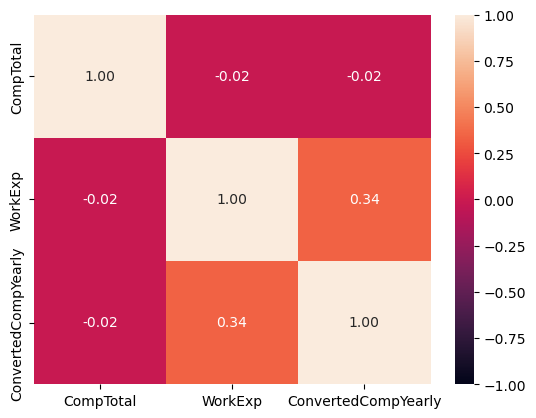

In [17]:
sns.heatmap(java.select_dtypes('float64', 'int').corr(), vmin=-1, vmax=1, annot=True, fmt='.2f') # numerical variables are not explicative of objective variable

In [18]:
survey_schema = pd.DataFrame({'question': survey.columns}).merge(schema[['qname', 'question']], left_on='question', right_on='qname', how='left')

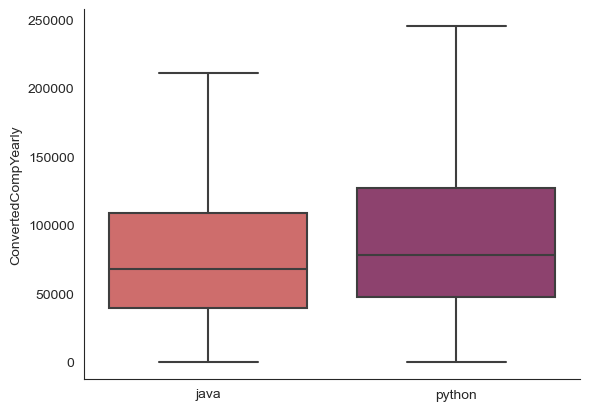

In [19]:
combined_dfs = pd.DataFrame({'java': java['ConvertedCompYearly'],
                             'python': python['ConvertedCompYearly']})
sns.set_style('white')
sns.boxplot(data=combined_dfs, palette='flare', showfliers=False)
sns.despine()
plt.ylabel('ConvertedCompYearly')
plt.show()

AISearchWantToWorkWith


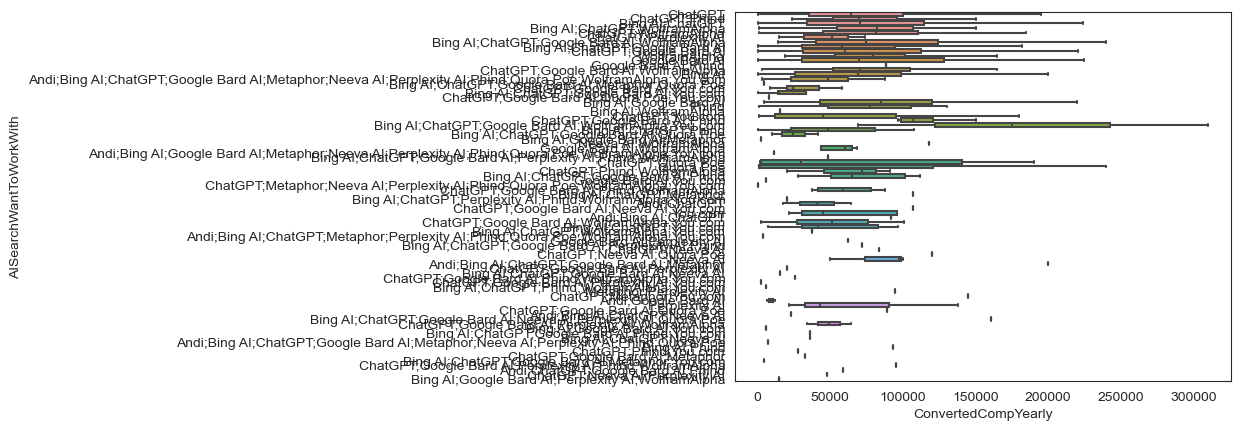

In [20]:
column = java.columns[40]
print(column)
sns.boxplot(data=java, x='ConvertedCompYearly', y=column, showfliers=False);

In [21]:
objective_variable = ['ConvertedCompYearly']
categorical_variables = java.select_dtypes(include=['object']).columns

excluir = ['Python or Java', 'Currency']#, 'LanguageHaveWorkedWith'] + [x for x in categorical_variables if re.search('Want', x)]
categorical_variables = categorical_variables[~categorical_variables.isin(excluir)]
# categorical_variables = ['Age', 'Employment', 'RemoteWork', 'EdLevel', 'YearsCodePro', 'AIAcc', 'AIToolInterested in Using', 'AINextNeither different nor similar', 'Frequency_2', 'SurveyEase']

# ['LanguageHaveWorkedWith'] + 

In [22]:
categorical_variables

Index(['MainBranch', 'Age', 'Employment', 'RemoteWork', 'CodingActivities',
       'EdLevel', 'LearnCode', 'LearnCodeOnline', 'LearnCodeCoursesCert',
       'YearsCode', 'YearsCodePro', 'DevType', 'OrgSize', 'PurchaseInfluence',
       'TechList', 'BuyNewTool', 'Country', 'LanguageHaveWorkedWith',
       'LanguageWantToWorkWith', 'DatabaseHaveWorkedWith',
       'DatabaseWantToWorkWith', 'PlatformHaveWorkedWith',
       'PlatformWantToWorkWith', 'WebframeHaveWorkedWith',
       'WebframeWantToWorkWith', 'MiscTechHaveWorkedWith',
       'MiscTechWantToWorkWith', 'ToolsTechHaveWorkedWith',
       'ToolsTechWantToWorkWith', 'NEWCollabToolsHaveWorkedWith',
       'NEWCollabToolsWantToWorkWith', 'OpSysPersonal use',
       'OpSysProfessional use', 'OfficeStackAsyncHaveWorkedWith',
       'OfficeStackAsyncWantToWorkWith', 'OfficeStackSyncHaveWorkedWith',
       'OfficeStackSyncWantToWorkWith', 'AISearchHaveWorkedWith',
       'AISearchWantToWorkWith', 'AIDevHaveWorkedWith', 'AIDevWantToWorkW

Imputing missing values

In [23]:
java_selected = pd.concat([java[categorical_variables], java[objective_variable]], axis=1).reset_index(drop=True)
python_selected = pd.concat([python[categorical_variables], python[objective_variable]], axis=1).reset_index(drop=True)

In [24]:
java_selected.shape
python_selected.shape

(14973, 78)

In [25]:
java_selected.describe(include='all')

,MainBranch,Age,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,TechList,BuyNewTool,Country,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,OpSysPersonal use,OpSysProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,AISearchHaveWorkedWith,AISearchWantToWorkWith,AIDevHaveWorkedWith,AIDevWantToWorkWith,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOComm,AISelect,AISent,AIAcc,AIBen,AIToolInterested in Using,AIToolCurrently Using,AIToolNot interested in Using,AINextVery different,AINextNeither different nor similar,AINextSomewhat similar,AINextVery similar,AINextSomewhat different,TBranch,ICorPM,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Knowledge_8,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,ProfessionalTech,Industry,SurveyLength,SurveyEase,ConvertedCompYearly
count,6302,6302,6299,6287,6285,6302,6293,4919,2920,6288,6274,6282,6297,6295,3606,6063,6302,6302,5854,5865,4891,4868,3906,5221,4460,4578,3798,5961,5195,6250,5594,6217,5884,5659,4402,6164,5175,3551,2889,1432,1031,6302,6281,6301,4995,6293,6302,4117,2272,4111,1965,2133,1295,674,419,386,158,1352,6093,4355,4280,4203,4223,4222,4215,4214,4208,4198,4252,4254,4184,4305,4292,4263,3732,6245,6247,6302.000000
unique,2,7,12,3,75,8,421,1830,118,52,50,33,10,3,3,153,132,2847,3048,2133,1704,952,781,1849,1625,1070,1172,3196,2653,2295,1632,590,516,1029,682,1388,852,60,80,33,44,15,5,3,6,6,3,6,47,5,374,187,205,104,55,48,38,115,2,2,5,5,5,5,5,5,5,5,5,5,5,5,5,199,12,3,3,NaN
top,I am a developer by profession,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Online Courses or Certi...,Formal documentation provided by the owner of ...,Udemy,10,5,"Developer, full-stack",100 to 499 employees,I have little or no influence,Investigate,Start a free trial;Ask developers I know/work ...,United States of America,Java,Java,PostgreSQL,PostgreSQL,Amazon Web Services (AWS),Amazon Web Services (AWS),Spring Boot,Spring Boot,Spring Framework,Spring Framework,Maven (build tool),Maven (build tool),IntelliJ IDEA;Visual Studio Code,IntelliJ IDEA;Visual Studio Code,Windows,MacOS,Confluence;Jira,Jira,Microsoft Teams,Microsoft Teams,ChatGPT,ChatGPT,GitHub Copilot,GitHub Copilot,Stack Overflow;Stack Exchange,A few times per week,Yes,Less than once per month or monthly,"No, not really",Yes,Favorable,Increase productivity;Greater efficiency;Speed...,Somewhat trust,Learning about a codebase;Project planning;Wri...,Writing code,Collaborating with teammates,Writing code,Writing code,Writing code,Writing code,Writing code,Yes,Individual contributor,Agree,Agree,Agree,Agree,Agree,Agree,Agree,Agree,1-2 times a week,1-2 times a week,1-2 times a week,30-60 minutes a day,15-30 minutes a day,DevOps function;Microservices;Automated testin...,"Information Services, IT, Software Development...",Appropriate in length,Easy,NaN
freq,6096,2904,5240,2935,1498,3152,261,97,722,509,512,2541,1271,2645,3159,1074,1116,297,172,380,492,1049,810,553,451,925,484,216,162,486,427,1292,1231,829,594,696,582,2354,1542,993,714,3635,2080,5006,2714,2059,2296,2030,379,1558,88,389,114,87,106,151,62,360,4373,3811,2062,1425,1675,1882,2250,1587,1575,1646,2726,1992,2246,1664,1420,376,1809,4880,4028,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [26]:
java_selected.dropna(subset=categorical_variables, how='all', axis=0, inplace=True) #empty rows
java_selected.dropna(how='all', axis=1, inplace=True) #empty columns
print(java_selected.shape)

python_selected.dropna(subset=categorical_variables, how='all', axis=0, inplace=True) #empty rows
python_selected.dropna(how='all', axis=1, inplace=True) #empty columns
print(python_selected.shape)

(6302, 78)
(14973, 78)


In [27]:
for columna in java_selected[categorical_variables]: 
    java_selected[columna].fillna(java_selected[columna].mode(), inplace=True)

# java_selected.apply(lambda x: x.fillna(x.value_counts().index[0], inplace=True, axis=0)) # filla na

In [28]:
def create_dummy_df(df, categorical_variables):
  for columna in categorical_variables:
    try:
      df = pd.concat([df.drop(columna, axis=1), pd.get_dummies(df[columna], prefix=columna, prefix_sep='_', drop_first=True, dummy_na=False)], axis=1)
    except:
      continue
  return df

java_dummy = create_dummy_df(java_selected, categorical_variables)
python_dummy = create_dummy_df(python_selected, categorical_variables)

# Model

In [29]:
print(java_dummy.shape)
print(python_dummy.shape)

(6302, 36575)
(14973, 75892)


In [30]:
from sklearn.preprocessing import normalize, Normalizer

java_explanatory_variables = java_dummy.columns[java_dummy.columns != 'ConvertedCompYearly']
# normalized = normalize(java_dummy[java_explanatory_variables], axis=1)
normalized = Normalizer().fit_transform(X=java_dummy[java_explanatory_variables], y=java_dummy['ConvertedCompYearly'])
java_normalized = pd.concat(
    [pd.DataFrame(normalized, columns=java_explanatory_variables), java_dummy['ConvertedCompYearly']], 
    axis=1
)

In [31]:
python_explanatory_variables = python_dummy.columns[python_dummy.columns != 'ConvertedCompYearly']
normalized = Normalizer().fit_transform(X=python_dummy[python_explanatory_variables], y=python_dummy['ConvertedCompYearly'])
python_normalized = pd.concat(
    [pd.DataFrame(normalized, columns=python_explanatory_variables), python_dummy['ConvertedCompYearly']], 
    axis=1
)

In [32]:
java_X = java_normalized[java_explanatory_variables]
java_y = java_normalized['ConvertedCompYearly']
java_X_train, java_X_test, java_y_train, java_y_test = train_test_split(java_X, java_y, test_size=0.3, random_state=42)

python_X = python_normalized[python_explanatory_variables]
python_y = python_normalized['ConvertedCompYearly']
python_X_train, python_X_test, python_y_train, python_y_test = train_test_split(python_X, python_y, test_size=0.3, random_state=42)

MemoryError: Unable to allocate 8.47 GiB for an array with shape (75892, 14973) and data type float64

In [ ]:
java_lm_model = LinearRegression().fit(java_X_train, java_y_train)

java_y_train_prediction = java_lm_model.predict(java_X_train)
java_y_test_prediction = java_lm_model.predict(java_X_test)

# Evaluar el modelo
train_score = r2_score(java_y_train, java_y_train_prediction)
test_score = r2_score(java_y_test, java_y_test_prediction)
print('Java R2 score en entrenamiento:', train_score)
print('Java R2 score en prueba:', test_score)

# Visualizar las predicciones vs. valores reales
# plt.scatter(y_test, y_test_prediction)
# plt.xlabel('Valores reales')
# plt.ylabel('Predicciones')
# plt.title('Predicciones vs. Valores reales')
# plt.show()

In [ ]:
python_lm_model = LinearRegression().fit(python_X_train, python_y_train)

python_y_train_prediction = python_lm_model.predict(python_X_train)
python_y_test_prediction = python_lm_model.predict(python_X_test)

# Evaluar el modelo
train_score = r2_score(python_y_train, python_y_train_prediction)
test_score = r2_score(python_y_test, python_y_test_prediction)
print('Python R2 score en entrenamiento:', train_score)
print('Python R2 score en prueba:', test_score)

# Visualizar las predicciones vs. valores reales
# plt.scatter(y_test, y_test_prediction)
# plt.xlabel('Valores reales')
# plt.ylabel('Predicciones')
# plt.title('Predicciones vs. Valores reales')
# plt.show()

In [ ]:
cutoffs = [4000, 3000, 2000, 1000, 500, 400, 300, 200, 100, 50, 40, 30, 20, 10, 9, 8, 7, 6, 5, 0]
cutoffs = [4000 - 10*i for i in range(396)]

def find_optimal_lm_mod(X, y, cutoffs, test_size=.30, random_state=42, plot=True): 
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
      
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    
    for cutoff in cutoffs:

        #reduce X matrix
        columns = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]].columns
        reduce_X = pd.DataFrame(normalize(X[columns], axis=1), columns=columns)
        num_feats.append(len(columns))

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size=test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression().fit(X_train, y_train)
        y_train_prediction = lm_model.predict(X_train)
        y_test_prediction = lm_model.predict(X_test)

        #append the r2 value from the test set
        r2_scores_train.append(r2_score(y_train, y_train_prediction))
        r2_scores_test.append(r2_score(y_test, y_test_prediction))
        results[str(cutoff)] = r2_score(y_test, y_test_prediction)

    if plot: 
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc='upper left')
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    columns = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]].columns
    normalized = normalize(X[columns], axis=1)
    df_normalized = pd.concat([pd.DataFrame(normalized, columns=columns), y], axis=1)
    num_feats.append(reduce_X.shape[1])
    
    reduce_X = df_normalized[columns]
    y = df_normalized['ConvertedCompYearly']

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression()
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, num_feats, lm_model, X_train, X_test, y_train, y_test

In [ ]:
X = java_dummy[java_explanatory_variables]
y = java_dummy['ConvertedCompYearly']
r2_scores_test, r2_scores_train, num_feats, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

In [ ]:
X = python_dummy[python_explanatory_variables]
y = python_dummy['ConvertedCompYearly']
r2_scores_test, r2_scores_train, num_feats, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

In [ ]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

In [ ]:
df = pd.DataFrame({'num_feats': num_feats[:-1], 'train': r2_scores_train, 'test': r2_scores_test})
df.set_index('num_feats').diff().sort_values(by=['num_feats', 'test'], ascending=False)
df.sort_values(by='test', ascending=False)

print(X_train.shape[1]) #Number of columns
print(r2_scores_test[np.argmax(r2_scores_test)]) # The model we should implement test_r2
print(r2_scores_train[np.argmax(r2_scores_test)]) # The model we should implement train_r2